In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd
import matplotlib.pyplot as plt

dataset_dir = "dataset"
raw_img_dir = os.path.join(dataset_dir, "raw-img")

if os.path.exists(raw_img_dir) and len(os.listdir(raw_img_dir)) > 0:
    print(f"Dataset already exists at {raw_img_dir}. Skipping download.")
else:
    print("Dataset not found. Attempting to download...")
    try:
        import kagglehub
        dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10", path=dataset_dir)
        print(f"Dataset downloaded to: {dataset_path}")
    except ImportError:
        print("kagglehub not found. Please install it using 'pip install kagglehub'")
        print("Attempting manual download...")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print(f"Please ensure kagglehub is properly configured and the dataset exists.")
        print(f"You can also manually download the dataset from Kaggle to {dataset_dir}")

100%|██████████| 586M/586M [00:35<00:00, 17.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\mfave\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2


In [8]:
data = []
for class_name in os.listdir(f"{dataset_dir}/raw-img"):
    for filename in os.listdir(f"{dataset_dir}/raw-img/{class_name}"):
        data.append({"filename": f"{dataset_dir}/raw-img/{class_name}/{filename}", "class": class_name})

df = pd.DataFrame(data)
df.to_csv(f"{dataset_dir}/_annotations.csv", index=False)

In [10]:
# Read the annotations file
df = pd.read_csv(f"{dataset_dir}/_annotations.csv")

# Create train, test, valid directories
for split in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(dataset_dir, split), exist_ok=True)

# Split the data
train_df, test_valid_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, stratify=test_valid_df['class'], random_state=42)

# Function to copy files and create new annotations
def process_split(split_df, split_name):
    new_annotations = []
    for _, row in split_df.iterrows():
        src = row['filename']
        dst = os.path.join(dataset_dir, split_name, os.path.basename(src))
        shutil.copy(src, dst)
        new_annotations.append({'filename': os.path.basename(src), 'class': row['class']})
    
    new_df = pd.DataFrame(new_annotations)
    new_df.to_csv(os.path.join(dataset_dir, f'{split_name}_annotations.csv'), index=False)

# Process each split
process_split(train_df, 'train')
process_split(valid_df, 'valid')
process_split(test_df, 'test')

print("Data split and reorganized into train, test, and valid directories.")


Data split and reorganized into train, test, and valid directories.


In [19]:
# Set up paths
dataset_dir = "dataset"
raw_img_dir = os.path.join(dataset_dir, "raw-img")
annotations_file = os.path.join(dataset_dir, "_annotations.csv")

# Create annotations file if it doesn't exist
if not os.path.exists(annotations_file):
    data = []
    for class_name in os.listdir(raw_img_dir):
        class_dir = os.path.join(raw_img_dir, class_name)
        for filename in os.listdir(class_dir):
            data.append({"filename": os.path.join(class_dir, filename), "class": class_name})
    
    df = pd.DataFrame(data)
    df.to_csv(annotations_file, index=False)

# Read the annotations file
df = pd.read_csv(annotations_file)

# Create train, test, valid directories
for split in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(dataset_dir, split), exist_ok=True)

# Split the data
train_df, test_valid_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, stratify=test_valid_df['class'], random_state=42)

# Function to create new annotations
def create_split_annotations(split_df, split_name):
    split_dir = os.path.join(dataset_dir, split_name)
    split_df['filename'] = split_df['filename'].apply(lambda x: os.path.join(split_dir, os.path.basename(x)))
    split_df.to_csv(os.path.join(dataset_dir, f'{split_name}_annotations.csv'), index=False)

# Create split annotations
create_split_annotations(train_df, 'train')
create_split_annotations(valid_df, 'valid')
create_split_annotations(test_df, 'test')

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(dataset_dir, 'train_annotations.csv')),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(dataset_dir, 'valid_annotations.csv')),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print(f"Found {len(train_generator.filenames)} images belonging to {len(train_generator.class_indices)} classes in the training set.")
print(f"Found {len(validation_generator.filenames)} images belonging to {len(validation_generator.class_indices)} classes in the validation set.")

Found 18325 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.
Found 18325 images belonging to 10 classes in the training set.
Found 3927 images belonging to 10 classes in the validation set.


Epoch 1/50
286/286 [==============================] - 145s 504ms/step - loss: 2.2176 - accuracy: 0.1891 - val_loss: 2.1656 - val_accuracy: 0.2090
Epoch 2/50
286/286 [==============================] - 126s 440ms/step - loss: 2.1522 - accuracy: 0.2182 - val_loss: 2.1137 - val_accuracy: 0.2541
Epoch 3/50
286/286 [==============================] - 124s 432ms/step - loss: 2.1056 - accuracy: 0.2367 - val_loss: 2.0436 - val_accuracy: 0.2736
Epoch 4/50
286/286 [==============================] - 123s 430ms/step - loss: 2.0684 - accuracy: 0.2514 - val_loss: 2.0271 - val_accuracy: 0.2802
Epoch 5/50
286/286 [==============================] - 122s 427ms/step - loss: 2.0228 - accuracy: 0.2677 - val_loss: 1.9753 - val_accuracy: 0.2935
Epoch 6/50
286/286 [==============================] - 122s 427ms/step - loss: 1.9973 - accuracy: 0.2827 - val_loss: 1.9335 - val_accuracy: 0.3309
Epoch 7/50
286/286 [==============================] - 123s 429ms/step - loss: 1.9575 - accuracy: 0.3006 - val_loss: 1.9111 -

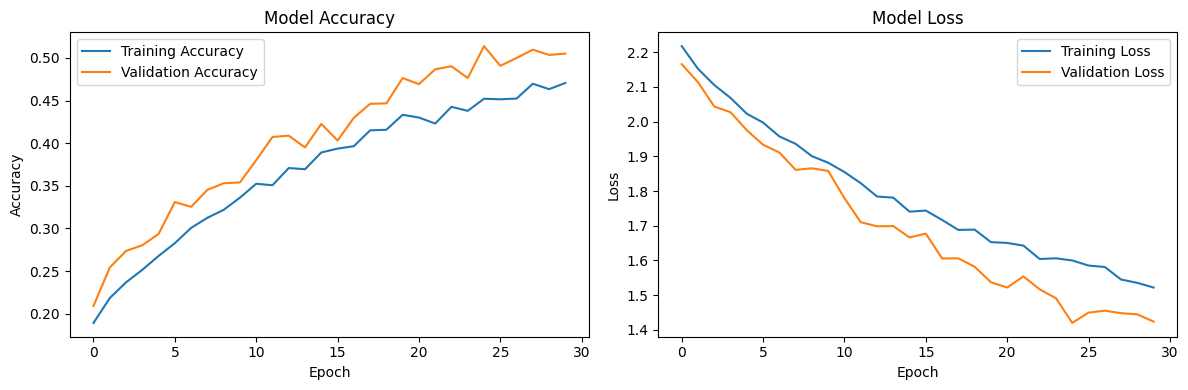

NameError: name 'test_generator' is not defined

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Assuming input_shape and num_classes are defined
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

model = create_cnn_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[early_stop]
)


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.4f}')

# Save the model
model.save('animal_classification_model.tf')
print("Model saved as animal_classification_model.tf")

In [ ]:


# Load the saved model
model = tf.keras.models.load_model('animal_classification_model.tf')

# Function to preprocess the image
def preprocess_image(image_path):
    # Load and resize image
    img = load_img(image_path, target_size=(224, 224))
    # Convert to array and add batch dimension
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize pixel values
    img_array = img_array / 255.0
    return img_array, img

# Function to predict and display results
def predict_and_display(image_path):
    # Get class names from your training data
    class_names = list(train_generator.class_indices.keys())
    
    # Preprocess the image
    img_array, original_img = preprocess_image(image_path)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    
    # Display image and results
    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
    plt.show()
    
    # Print top 3 predictions
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {predictions[0][idx]*100:.2f}%")

# Example usage - replace with path to your test image
test_image_path = "dataset/test/your_test_image.jpg"  # Replace with actual path
predict_and_display(test_image_path)